
# Write DICOM data

This example shows how to write a DICOM file from scratch using pydicom. This
example does not produce a DICOM standards compliant file as written, you will
have to change UIDs to valid values and add all required DICOM data elements.


In [27]:
import random

from pydicom import dcmread
from pydicom.dataset import FileDataset, FileMetaDataset
from pydicom.uid import UID

# creates Dicom images with meta data from raw .dcm files
def create_volume(input_fpath='../data/dicom/real/104_HM10395 P104/2819497684894126 p4/CT P4 P104 S106 I0 Gated 80.0',
                  output_fpath='../data/dicom/random/test3/'):

  _PatientName = 'Peter Pan'
  _PatientID = '100_HM10001'
  _SeriesInstanceUID = '2'
  _StudyInstanceUID = '1'
  _SeriesDescription = 'There is no pneumonia. '

  relevant_slices = set()
  for i in range(50):
    # copy 50 text images
    fpath = input_fpath + "/CT" + ((6-len(str(i)))*"0" +str(i))+".dcm"
    print(fpath)
    ds = dcmread(fpath)

    # modify metadata
    ds.PatientName = _PatientName
    ds.PatientID = _PatientID
    ds.SeriesInstanceUID = _SeriesInstanceUID
    ds.StudyInstanceUID = _StudyInstanceUID
    ds.SeriesDescription = _SeriesDescription
    ds.FrameOfReferenceUID = str(i)
    ds.SeriesNumber = '2'
    ds.SOPInstanceUID= '1.2.3.'+str(i)

    ds.StudyDate='20240430'
    ds.SliceLocation = str(i)

    # image size is 512x512, values from -2000,0

    # modify image
    for j in range(ds.Rows):
      for k in range(ds.Columns):

        if (j-200)**2 +(k-200)**2  + (ds.InstanceNumber -25)**2<= 10**2: # a spehere with radius
          #ds.pixel_array[j,k] = random.randint(0, 500)

          if (j-200)**2 +(k-200)**2  + (ds.InstanceNumber -25)**2<= 2: # get the most important slices
            relevant_slices.add(i)

      ds.PixelData = ds.pixel_array.tobytes() # write changes back to pixel data

    break
    ds.save_as(output_fpath +"out"+str(i)+".dcm")

  print(relevant_slices)
create_volume()

../data/dicom/real/104_HM10395 P104/2819497684894126 p4/CT P4 P104 S106 I0 Gated 80.0/CT000000.dcm
[[-2000 -2000 -2000 ... -2000 -2000 -2000]
 [-2000 -2000 -2000 ... -2000 -2000 -2000]
 [-2000 -2000 -2000 ... -2000 -2000 -2000]
 ...
 [-2000 -2000 -2000 ... -2000 -2000 -2000]
 [-2000 -2000 -2000 ... -2000 -2000 -2000]
 [-2000 -2000 -2000 ... -2000 -2000 -2000]]
set()


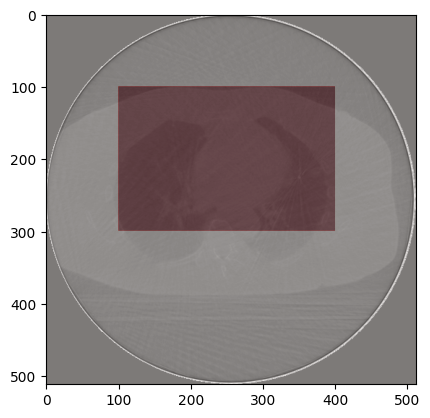

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from pydicom import dcmread
from pydicom.dataset import Dataset, FileDataset
from pydicom.sequence import Sequence

fpath = '../data/dicom/real/104_HM10395 P104/2819497684894126 p4/CT P4 P104 S106 I0 Gated 80.0/CT000000.dcm'
ds = dcmread(fpath)

rows, cols = ds.Rows, ds.Columns
overlay_array = np.zeros((rows, cols), dtype=np.uint8)

# Define the rectangle for the overlay
# (start_row, start_col, height, width)
rect = (100, 100, 200, 300)  # Adjust this as needed
overlay_array[rect[0]:rect[0]+rect[2], rect[1]:rect[1]+rect[3]] = 1

# Convert the numpy array (binary image) to a packed bit array for DICOM
overlay_packed = np.packbits(overlay_array, axis=-1)

overlay_group = 0x6000
ds.add_new((overlay_group, 0x0010), 'US', rows)  # Overlay Rows
ds.add_new((overlay_group, 0x0011), 'US', cols)  # Overlay Columns
ds.add_new((overlay_group, 0x0040), 'CS', 'G')   # Overlay Type
ds.add_new((overlay_group, 0x0100), 'US', 1)     # Overlay Bits Allocated
ds.add_new((overlay_group, 0x0102), 'US', 0)     # Overlay Bit Position
ds.add_new((overlay_group, 0x0050), 'SS', [1, 1])  # Overlay Origin
ds.add_new((overlay_group, 0x3000), 'OW', overlay_packed.tobytes())  # Overlay Data

ds.save_as("output_with_overlay.dcm")

# Plot the original image and the overlay for verification
plt.imshow(ds.pixel_array, cmap='gray')
plt.imshow(overlay_array, alpha=0.3, cmap='Reds')  # overlay with semi-transparency
plt.show()

In [24]:
import nibabel as nib
import pydicom
import numpy as np
import os
from pydicom.dataset import Dataset, FileDataset
from datetime import datetime
from pydicom.uid import generate_uid
import matplotlib.pyplot as plt

import simple_orthanc

def upload_dicom_folder(dicom_folder):
    # Initialize the Orthanc client
    orthanc = simple_orthanc.Orthanc()
    orthanc.upload_folder(dicom_folder, test_dicom=True, recursive=True)

def nifti_to_dicom(nifti_file,
    output_folder,
    series_description,
    series_instance_uid=generate_uid(),
    series_number="1",
    reference_dicom_file = "../data/dicom/real/extensive-consolidation-v2-sampl/image.0001.dcm",
    modality='CT',
    study_instance_uid = '1.3.6.1.4.1.14519.5.2.1.6834.5010.119076582718824960697635220329', # should be different for AI/non-AI
    study_id='1', # should be different for AI/non-AI
    accession_number = '1', # should be the same for AI/non-AI
    patient_name="Generative AI Patient",
    patient_id="MedSyn",
    description="",

    ):
    rotate=""
    if modality=='AI':
        content_date="19000101"
        rotate="counterclockwise"
    else:
        content_date = str(datetime.now().date()).replace('-', '')
        rotate="clockwise"

    # Load the NIfTI file
    img = nib.load(nifti_file)
    data = img.get_fdata()
    affine = img.affine

    # Ensure output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Initialize common dataset attributes
    ds = pydicom.dcmread(reference_dicom_file)
    ds.PatientName = patient_name
    ds.PatientID = patient_id
    ds.AccessionNumber = accession_number
    ds.StudyInstanceUID = study_instance_uid
    ds.SeriesInstanceUID = series_instance_uid
    ds.SeriesDescription= series_description
    ds.Modality = modality
    ds.SeriesNumber = series_number
    ds.StudyID = study_id
    ds.StudyDescription = description
    ds.Manufacturer = "PythonDicomConversion"
    ds.Rows, ds.Columns = data.shape[:2]
    ds.SliceThickness = float(affine[2, 2])

    ds.SamplesPerPixel = 1
    ds.BitsAllocated = 16
    ds.BitsStored = 16
    ds.HighBit = 15
    ds.PixelRepresentation = 0  # 1 means signed integers




    # Set additional metadata
    ds.ContentDate = content_date
    ds.ContentTime = str(datetime.now().time()).replace(':', '').split('.')[0]

    ds.StudyDate = ds.ContentDate
    ds.StudyTime = ds.ContentTime
    ds.PatientSex = "O"
    ds.PatientBirthDate = "19000101"


    # Scale pixel data if necessary (e.g., to avoid issues with pixel value ranges)
    data = data - np.min(data)
    data = data / np.max(data) * (2**16 - 1)
    data = data.astype('uint16')

    # reverse in 3rd axis
    #data = data[:,:,::-1]
    # Rotate each slice to the left (90 degrees counterclockwise)
    if rotate == "counterclockwise":
        data = np.rot90(data, k=1, axes=(0, 1))
    elif rotate == "clockwise":
        data = np.rot90(data, k=3, axes=(0, 1))
    
    #print(data)
    # Iterate over each slice and update the dataset
    for i in range(data.shape[2]):
        slice_data = data[:, :, -(i+1)]

        # Update slice-specific attributes
        ds.SOPInstanceUID= generate_uid()
        ds.InstanceNumber = i + 1
        ds.ImagePositionPatient = [0,0,-i] 
        ds.SliceLocation = i * ds.SliceThickness



        # Convert pixel data to the appropriate type and flatten the array
        ds.PixelData = slice_data.tobytes()

        # Visualize the slice
        # plt.imshow(slice_data, cmap='gray')
        # plt.title(f'Slice {i}')
        # plt.show()

        # Save the DICOM file
        dicom_filename = os.path.join(output_folder, f"slice_{i:03d}.dcm")
        ds.save_as(dicom_filename)

    print(f"Conversion complete. DICOM files are saved in {output_folder}")
    upload_dicom_folder(output_folder)
    print("Files Uploaded to Orthanc Server Localhost")


# CT-Rate


## Example 1
- Arterial wall calcification
- Atelectasis
- Lung opacity
- Consolidation

### Original


In [21]:
findings = "Multiple venous collaterals are present in the anterior left chest wall and are associated with the anterior jugular vein at the level of the right sternoclavicular junction. Left subclavian vein collapsed (chronic occlusion pathology?). Trachea, both main bronchi are open. Calcific plaques are observed in the aortic arch. Other mediastinal main vascular structures, heart contour, size are normal. Thoracic aorta diameter is normal. Pericardial effusion-thickening was not observed. Thoracic esophagus calibration was normal and no significant tumoral wall thickening was detected. No enlarged lymph nodes in prevascular, pre-paratracheal, subcarinal or bilateral hilar-axillary pathological dimensions were detected. When examined in the lung parenchyma window; Linear atelectasis is present in both lung parenchyma. Subsegmental atelectasis is observed in the right middle lobe. Thickening of the bronchial wall and peribronchial budding tree-like reticulonodular densities are observed in the bilateral lower lobes. Peribronchial minimal consolidation is seen in the lower lobes in places. The findings were evaluated primarily in favor of the infectious process. The left kidney partially entering the section is atrophic. The right kidney could not be evaluated because it did not enter the section. Other upper abdominal organs included in the sections are normal. No space-occupying lesion was detected in the liver that entered the cross-sectional area. Bilateral adrenal glands were normal and no space-occupying lesion was detected. There are osteophytes with anterior extension in the thoracic vertebrae."
impressions="Multiple venous collaterals in the anterior left chest wall and collapsed appearance in the left subclavian vein (chronic occlusion?).  Thickening of the bronchial wall in both lungs.  Peribronchial reticulonodular densities in the lower lobes, minimal consolidations (infection process?).  Atelectasis in both lungs.  Thoracic spondylosis."
description="Arterial wall calcification, Atelectasis, Lung opacity, Consolidation"
nifti_file = '../data/nifti/ct-rate/train/train_1_a_1.nii.gz'
output_folder = '../data/nifti/ct-rate/train/train_1_a_1/original/'
nifti_to_dicom(nifti_file=nifti_file, 
               output_folder=output_folder,
               series_description="", 
               modality = "CT",
               study_instance_uid='1.1.1',
               study_id='1', 
               accession_number='1.1.1',
               patient_name="Example Patient 1",
               patient_id="train_1_a_1",
               description=description,
               )


20240528


c:\Users\mot99\miniconda3\envs\ohif-python\Lib\site-packages\pydicom\valuerep.py:443: UserWarning: The value length (69) exceeds the maximum length of 64 allowed for VR LO.
  warnings.warn(msg)


Conversion complete. DICOM files are saved in ../data/nifti/ct-rate/train/train_1_a_1/original/


### Generated

In [12]:
findings = "Multiple venous collaterals are present in the anterior left chest wall and are associated with the anterior jugular vein at the level of the right sternoclavicular junction. Left subclavian vein collapsed (chronic occlusion pathology?). Trachea, both main bronchi are open. Calcific plaques are observed in the aortic arch. Other mediastinal main vascular structures, heart contour, size are normal. Thoracic aorta diameter is normal. Pericardial effusion-thickening was not observed. Thoracic esophagus calibration was normal and no significant tumoral wall thickening was detected. No enlarged lymph nodes in prevascular, pre-paratracheal, subcarinal or bilateral hilar-axillary pathological dimensions were detected. When examined in the lung parenchyma window; Linear atelectasis is present in both lung parenchyma. Subsegmental atelectasis is observed in the right middle lobe. Thickening of the bronchial wall and peribronchial budding tree-like reticulonodular densities are observed in the bilateral lower lobes. Peribronchial minimal consolidation is seen in the lower lobes in places. The findings were evaluated primarily in favor of the infectious process. The left kidney partially entering the section is atrophic. The right kidney could not be evaluated because it did not enter the section. Other upper abdominal organs included in the sections are normal. No space-occupying lesion was detected in the liver that entered the cross-sectional area. Bilateral adrenal glands were normal and no space-occupying lesion was detected. There are osteophytes with anterior extension in the thoracic vertebrae."
impressions="Multiple venous collaterals in the anterior left chest wall and collapsed appearance in the left subclavian vein (chronic occlusion?).  Thickening of the bronchial wall in both lungs.  Peribronchial reticulonodular densities in the lower lobes, minimal consolidations (infection process?).  Atelectasis in both lungs.  Thoracic spondylosis."
description="Arterial wall calcification, Atelectasis, Lung opacity, Consolidation"
nifti_file = '../data/nifti/ct-rate/img_256_standard/train_1_a_1_sample_0.nii.gz'
output_folder = '../data/nifti/ct-rate/train/train_1_a_1/generated/train_1_a_1_sample_0/'
nifti_to_dicom(nifti_file=nifti_file, 
               output_folder=output_folder,
               series_description=impressions, 
               modality = "AI",
               study_instance_uid='1.1.2',
               study_id='2', 
               accession_number='1.1',
               patient_name="Example Patient 1",
               patient_id="train_1_a_1",
               description=description,
)


19000101
Conversion complete. DICOM files are saved in ../data/nifti/ct-rate/train/train_1_a_1/generated/train_1_a_1_sample_0/


In [13]:
findings = "Multiple venous collaterals are present in the anterior left chest wall and are associated with the anterior jugular vein at the level of the right sternoclavicular junction. Left subclavian vein collapsed (chronic occlusion pathology?). Trachea, both main bronchi are open. Calcific plaques are observed in the aortic arch. Other mediastinal main vascular structures, heart contour, size are normal. Thoracic aorta diameter is normal. Pericardial effusion-thickening was not observed. Thoracic esophagus calibration was normal and no significant tumoral wall thickening was detected. No enlarged lymph nodes in prevascular, pre-paratracheal, subcarinal or bilateral hilar-axillary pathological dimensions were detected. When examined in the lung parenchyma window; Linear atelectasis is present in both lung parenchyma. Subsegmental atelectasis is observed in the right middle lobe. Thickening of the bronchial wall and peribronchial budding tree-like reticulonodular densities are observed in the bilateral lower lobes. Peribronchial minimal consolidation is seen in the lower lobes in places. The findings were evaluated primarily in favor of the infectious process. The left kidney partially entering the section is atrophic. The right kidney could not be evaluated because it did not enter the section. Other upper abdominal organs included in the sections are normal. No space-occupying lesion was detected in the liver that entered the cross-sectional area. Bilateral adrenal glands were normal and no space-occupying lesion was detected. There are osteophytes with anterior extension in the thoracic vertebrae."
impressions="Multiple venous collaterals in the anterior left chest wall and collapsed appearance in the left subclavian vein (chronic occlusion?).  Thickening of the bronchial wall in both lungs.  Peribronchial reticulonodular densities in the lower lobes, minimal consolidations (infection process?).  Atelectasis in both lungs.  Thoracic spondylosis."
description="Arterial wall calcification, Atelectasis, Lung opacity, Consolidation"
nifti_file = '../data/nifti/ct-rate/img_256_standard/train_1_a_1_sample_1.nii.gz'
output_folder = '../data/nifti/ct-rate/train/train_1_a_1/generated/train_1_a_1_sample_1/'
nifti_to_dicom(nifti_file=nifti_file, 
               output_folder=output_folder,
               series_description=impressions, 
               modality = "AI",
               study_instance_uid='1.1.3',
               study_id='3', 
               accession_number='1.1',
               patient_name="Example Patient 1",
               patient_id="train_1_a_1",
               description=description,
)


19000101
Conversion complete. DICOM files are saved in ../data/nifti/ct-rate/train/train_1_a_1/generated/train_1_a_1_sample_1/


In [14]:
findings = "Multiple venous collaterals are present in the anterior left chest wall and are associated with the anterior jugular vein at the level of the right sternoclavicular junction. Left subclavian vein collapsed (chronic occlusion pathology?). Trachea, both main bronchi are open. Calcific plaques are observed in the aortic arch. Other mediastinal main vascular structures, heart contour, size are normal. Thoracic aorta diameter is normal. Pericardial effusion-thickening was not observed. Thoracic esophagus calibration was normal and no significant tumoral wall thickening was detected. No enlarged lymph nodes in prevascular, pre-paratracheal, subcarinal or bilateral hilar-axillary pathological dimensions were detected. When examined in the lung parenchyma window; Linear atelectasis is present in both lung parenchyma. Subsegmental atelectasis is observed in the right middle lobe. Thickening of the bronchial wall and peribronchial budding tree-like reticulonodular densities are observed in the bilateral lower lobes. Peribronchial minimal consolidation is seen in the lower lobes in places. The findings were evaluated primarily in favor of the infectious process. The left kidney partially entering the section is atrophic. The right kidney could not be evaluated because it did not enter the section. Other upper abdominal organs included in the sections are normal. No space-occupying lesion was detected in the liver that entered the cross-sectional area. Bilateral adrenal glands were normal and no space-occupying lesion was detected. There are osteophytes with anterior extension in the thoracic vertebrae."
impressions="Multiple venous collaterals in the anterior left chest wall and collapsed appearance in the left subclavian vein (chronic occlusion?).  Thickening of the bronchial wall in both lungs.  Peribronchial reticulonodular densities in the lower lobes, minimal consolidations (infection process?).  Atelectasis in both lungs.  Thoracic spondylosis."
description="Arterial wall calcification, Atelectasis, Lung opacity, Consolidation"
nifti_file = '../data/nifti/ct-rate/img_256_standard/train_1_a_1_sample_2.nii.gz'
output_folder = '../data/nifti/ct-rate/train/train_1_a_1/generated/train_1_a_1_sample_2/'
nifti_to_dicom(nifti_file=nifti_file, 
               output_folder=output_folder,
               series_description=impressions, 
               modality = "AI",
               study_instance_uid='1.1.4',
               study_id='4', 
               accession_number='1.1',
               patient_name="Example Patient 1",
               patient_id="train_1_a_1",
               description=description,
)


19000101
Conversion complete. DICOM files are saved in ../data/nifti/ct-rate/train/train_1_a_1/generated/train_1_a_1_sample_2/


## Example 2
- Arterial wall calcification
- Coronary artery wall calcification
- Lymphadenopathy
- Lung nodule
- Lung opacity


### Original 

In [16]:

findings = "Trachea, both main bronchi are open. Mediastinal main vascular structures, heart contour, size are normal. Pericardial effusion-thickening was not observed. Calcific plaques are present in the coronary arteries. Thoracic esophagus calibration was normal and no significant pathological wall thickening was detected. Millimetric lymph nodes with a short axis not exceeding 1 cm are observed in the mediastinum. When examined in the lung parenchyma window; Widespread ground glass densities are observed in both lung parenchyma showing a tendency to central and peripheral fusion. A 5 mm calcific nodule was observed in the posterobasal region of the lower lobe of the right lung. A millimetric hypodense lesion was observed in segment 2 of the liver in the upper abdominal organs included in the sections. Bone structures in the study area are natural. Osteodegenerative changes are observed in the vertebrae."
impressions=" Findings compatible with Covid pneumonia  Aortic and coronary artery atherosclerosis  Hypodense lesion (cyst?) in liver segment 2"
description= "Arterial wall calcification, Coronary artery wall calcification, Lymphadenopathy, Lung nodule, Lung opacity"
nifti_file = '../data/nifti/ct-rate/train/train_10_a_1.nii.gz'
output_folder = '../data/nifti/ct-rate/train/train_10_a_1/original/'
nifti_to_dicom(nifti_file=nifti_file, 
               output_folder=output_folder,
               series_description="", 
               modality = "CT",
               study_instance_uid='1.2.1',
               study_id='1', 
               accession_number='1.2.1',
               patient_name="Example Patient 2",
               patient_id="train_10_a_1",
               description= description,

               )


20240528


c:\Users\mot99\miniconda3\envs\ohif-python\Lib\site-packages\pydicom\valuerep.py:443: UserWarning: The value length (107) exceeds the maximum length of 64 allowed for VR LO.
  warnings.warn(msg)


Conversion complete. DICOM files are saved in ../data/nifti/ct-rate/train/train_10_a_1/original/


### Generated

In [ ]:
findings = "Trachea, both main bronchi are open. Mediastinal main vascular structures, heart contour, size are normal. Pericardial effusion-thickening was not observed. Calcific plaques are present in the coronary arteries. Thoracic esophagus calibration was normal and no significant pathological wall thickening was detected. Millimetric lymph nodes with a short axis not exceeding 1 cm are observed in the mediastinum. When examined in the lung parenchyma window; Widespread ground glass densities are observed in both lung parenchyma showing a tendency to central and peripheral fusion. A 5 mm calcific nodule was observed in the posterobasal region of the lower lobe of the right lung. A millimetric hypodense lesion was observed in segment 2 of the liver in the upper abdominal organs included in the sections. Bone structures in the study area are natural. Osteodegenerative changes are observed in the vertebrae."
impressions=" Findings compatible with Covid pneumonia  Aortic and coronary artery atherosclerosis  Hypodense lesion (cyst?) in liver segment 2"
description= "Arterial wall calcification, Coronary artery wall calcification, Lymphadenopathy, Lung nodule, Lung opacity"
nifti_file = '../data/nifti/ct-rate/img_256_standard/train_10_a_1_sample_0.nii.gz'
output_folder = '../data/nifti/ct-rate/train/train_10_a_1/generated/'
nifti_to_dicom(nifti_file=nifti_file, 
               output_folder=output_folder,
               series_description=impressions, 
               modality = "AI",
               study_instance_uid='1.2.2',
               study_id='2', 
               accession_number='1.2',
               patient_name="Example Patient 2",
               patient_id="train_10_a_1",
               description= description,

               )


# Example 3
- (Medical material)
- Pericardial effusion
- Emphysema
- Atelectasis
- Lung nodule
- Pleural effusion
- Consolidation


### Original 

In [9]:

findings = "A central venous catheter inserted from the right was observed. Trachea and both main bronchi are open and no obstructive pathology is detected. Mediastinal vascular structures and cardiac examination could not be evaluated optimally due to the lack of contrast. The pulmonary trunk caliber was measured at 30 mm and was wider than normal. Heart contour, the size is natural. There is minimal pericardial effusion. The effusion measuring approximately 80 mm in size is observed on the right. There is an area of increased density in the lung parenchyma adjacent to the effusion, which is considered secondary to compressive atelectasis. No pathological increase in wall thickness was observed in the thoracic esophagus. In the mediastinum, in both axillary regions and in the supraclavicular fossa, no lymph nodes were observed in pathological size and appearance. In the lower lobe of the left lung, there is an area of increase in density consistent with the consolidation observed in the air bronchograms. Although the appearance may be secondary to atelectasis, underlying pneumonic infiltration cannot be excluded. It is recommended to be evaluated together with clinical and laboratory findings. No mass lesion was observed in both lungs. There are a few millimetric nodules in the left lung, the largest of which is 5.5x3.5 mm in the upper lobe inferior lingular segment. Emphysematous changes were observed in both lungs. There are findings consistent with peritoneal carcinomatosis in the upper abdominal sections within the image, and hypodense lesions in the liver and spleen parenchyma that cannot be characterized in this examination. No lytic or destructive lesions were detected in the bone structures within the image."
impressions="Right pleural effusion, area of increased density in the adjacent lung parenchyma evaluated in favor of compressive atelectasis.  Density increase area in the lower lobe of the left lung consistent with the consolidation observed in air bronchograms; Pneumonic infiltration, which may be related to atelectasis, cannot be excluded. It is recommended to be evaluated together with clinical and laboratory findings.  A few millimetric nodules in the left lung."
description= "Pericardial effusion, Emphysema, Atelectasis, Lung nodule, Pleural effusion, Consolidation"
nifti_file = '../data/nifti/ct-rate/train/train_100_a_1.nii.gz'
output_folder = '../data/nifti/ct-rate/train/train_100_a_1/original/'
nifti_to_dicom(nifti_file=nifti_file, 
               output_folder=output_folder,
               series_description="", 
               modality = "CT",
               study_instance_uid='1.3.1',
               study_id='1', 
               accession_number='1.3.1',
               patient_name="Example Patient 3",
               patient_id="train_100_a_1",
               description= description,

               )

20240528


c:\Users\mot99\miniconda3\envs\ohif-python\Lib\site-packages\pydicom\valuerep.py:443: UserWarning: The value length (90) exceeds the maximum length of 64 allowed for VR LO.
  warnings.warn(msg)


Conversion complete. DICOM files are saved in ../data/nifti/ct-rate/train/train_100_a_1/original/


### Generated

In [ ]:
findings = "A central venous catheter inserted from the right was observed. Trachea and both main bronchi are open and no obstructive pathology is detected. Mediastinal vascular structures and cardiac examination could not be evaluated optimally due to the lack of contrast. The pulmonary trunk caliber was measured at 30 mm and was wider than normal. Heart contour, the size is natural. There is minimal pericardial effusion. The effusion measuring approximately 80 mm in size is observed on the right. There is an area of increased density in the lung parenchyma adjacent to the effusion, which is considered secondary to compressive atelectasis. No pathological increase in wall thickness was observed in the thoracic esophagus. In the mediastinum, in both axillary regions and in the supraclavicular fossa, no lymph nodes were observed in pathological size and appearance. In the lower lobe of the left lung, there is an area of increase in density consistent with the consolidation observed in the air bronchograms. Although the appearance may be secondary to atelectasis, underlying pneumonic infiltration cannot be excluded. It is recommended to be evaluated together with clinical and laboratory findings. No mass lesion was observed in both lungs. There are a few millimetric nodules in the left lung, the largest of which is 5.5x3.5 mm in the upper lobe inferior lingular segment. Emphysematous changes were observed in both lungs. There are findings consistent with peritoneal carcinomatosis in the upper abdominal sections within the image, and hypodense lesions in the liver and spleen parenchyma that cannot be characterized in this examination. No lytic or destructive lesions were detected in the bone structures within the image."
impressions="Right pleural effusion, area of increased density in the adjacent lung parenchyma evaluated in favor of compressive atelectasis.  Density increase area in the lower lobe of the left lung consistent with the consolidation observed in air bronchograms; Pneumonic infiltration, which may be related to atelectasis, cannot be excluded. It is recommended to be evaluated together with clinical and laboratory findings.  A few millimetric nodules in the left lung."
description= "Pericardial effusion, Emphysema, Atelectasis, Lung nodule, Pleural effusion, Consolidation"
nifti_file = '../data/nifti/ct-rate/img_256_standard/train_100_a_1_sample_0.nii.gz'
output_folder = '../data/nifti/ct-rate/train/train_100_a_1/generated/'
nifti_to_dicom(nifti_file=nifti_file, 
               output_folder=output_folder,
               series_description=impressions, 
               modality = "AI",
               study_instance_uid='1.3.2',
               study_id='2', 
               accession_number='1.3.2',
               patient_name="Example Patient 3",
               patient_id="train_100_a_1",
               description= description,
               )

# Example 4
- Lung nodule


### Original 

In [15]:
findings = "No lymph node was observed in the supraclavicular fossa and axilla in pathological size and appearance. Thyroid gland, left lobe and isthmus are operated. Heart dimensions and compartments appear natural. Pericardial effusion was not detected. Calibrations of mediastinal major vascular structures are natural. No pneumonic infiltration or consolidation area was detected in the lung parenchyma. No suspicious mass or nodular space-occupying lesion was observed in the lung parenchyma. There are a few nonspecific nodules less than 5 mm in diameter. In the evaluation of the upper abdominal organs, including the cross-section, there is a decrease in both kidney sizes and parenchyma thickness. No lytic-destructive lesions were detected in bone structures."
impressions="Thoracic CT examination within normal limits. Decrease in both kidney sizes and parenchyma thickness. Partially thyroidectomized"
description= "Lung nodule"
nifti_file = '../data/nifti/ct-rate/train/train_1000_a_1.nii.gz'
output_folder = '../data/nifti/ct-rate/train/train_1000_a_1/original/'

nifti_to_dicom(nifti_file=nifti_file,
               output_folder=output_folder,
               series_description="", 
               modality = "CT",
               study_instance_uid='1.4.1',
               study_id='1', 
               accession_number='1.4',
               patient_name="Example Patient 4",
               patient_id="train_1000_a_1",
               description= description
               )

Conversion complete. DICOM files are saved in ../data/nifti/ct-rate/train/train_1000_a_1/original/


## Generated

In [ ]:
findings = "No lymph node was observed in the supraclavicular fossa and axilla in pathological size and appearance. Thyroid gland, left lobe and isthmus are operated. Heart dimensions and compartments appear natural. Pericardial effusion was not detected. Calibrations of mediastinal major vascular structures are natural. No pneumonic infiltration or consolidation area was detected in the lung parenchyma. No suspicious mass or nodular space-occupying lesion was observed in the lung parenchyma. There are a few nonspecific nodules less than 5 mm in diameter. In the evaluation of the upper abdominal organs, including the cross-section, there is a decrease in both kidney sizes and parenchyma thickness. No lytic-destructive lesions were detected in bone structures."
impressions="Thoracic CT examination within normal limits. Decrease in both kidney sizes and parenchyma thickness. Partially thyroidectomized"
description= "Lung nodule"
nifti_file = '../data/nifti/ct-rate/img_256_standard/train_1000_a_1_sample_0.nii.gz'
output_folder = '../data/nifti/ct-rate/train/train_1000_a_1/generated/'

nifti_to_dicom(nifti_file=nifti_file,
               output_folder=output_folder,
               series_description=impressions, 
               modality = "AI",
               study_instance_uid='1.4.2',
               study_id='2', 
               accession_number='1.4',
               patient_name="Example Patient 4",
               patient_id="train_1000_a_1",
               description= description,
               )

# Example 5
- Arterial wall calcification
- Cardiomegaly
- Pericardial effusion
- Atelectasis
- Pleural effusion

### Original

In [16]:
findings = "The examination of the patient was evaluated by comparing it with the previous pulmonary CT angiography examination. The cardiothoracic ratio increased in favor of the heart. Minimal pericardial and bilateral pleural effusion are observed. Millimetric calcific plaques follow in the aorta. Trachea and both main bronchi are open. No occlusive pathology was detected in the trachea and both main bronchi. No pathologically enlarged lymph nodes were detected in the mediastinum and hilar regions.3.2021. There is an area of atelectasis accompanied by volume loss in the lingular segment of the left lung upper lobe. There are significant increases in interlobular septal thickness in the lower lobes of both lungs on the left. No mass was detected in both lungs. No pathological wall thickness increase was observed in the esophagus within the sections. In the upper abdominal organs within the sections, no mass with distinguishable borders was detected as far as it can be observed within the borders of non-enhanced CT. No lytic-destructive lesions were detected in the bone structures within the sections."
impressions="Cardiomegaly, minimal pericardial-pleural effusion. Consolidation areas in both lung lower lobes prominent on the left; is regressed. Atelectasis in the lingular segment of the left lung"
description= "Arterial wall calcification, Cardiomegaly, Pericardial effusion, Atelectasis, Pleural effusion"
nifti_file = '../data/nifti/ct-rate/train/train_1001_a_1.nii.gz'
output_folder = '../data/nifti/ct-rate/train/train_1001_a_1/original/'
nifti_to_dicom(nifti_file=nifti_file, 
               output_folder=output_folder,
               series_description="", 
               modality = "CT",
               study_instance_uid='1.5.1',
               study_id='1', 
               accession_number='1.5.1',
               patient_name="Example Patient 5",
               patient_id="train_1001_a_1",
               description= description,
               )



Conversion complete. DICOM files are saved in ../data/nifti/ct-rate/train/train_1001_a_1/original/


### Generated

In [ ]:
findings = "The examination of the patient was evaluated by comparing it with the previous pulmonary CT angiography examination. The cardiothoracic ratio increased in favor of the heart. Minimal pericardial and bilateral pleural effusion are observed. Millimetric calcific plaques follow in the aorta. Trachea and both main bronchi are open. No occlusive pathology was detected in the trachea and both main bronchi. No pathologically enlarged lymph nodes were detected in the mediastinum and hilar regions.3.2021. There is an area of atelectasis accompanied by volume loss in the lingular segment of the left lung upper lobe. There are significant increases in interlobular septal thickness in the lower lobes of both lungs on the left. No mass was detected in both lungs. No pathological wall thickness increase was observed in the esophagus within the sections. In the upper abdominal organs within the sections, no mass with distinguishable borders was detected as far as it can be observed within the borders of non-enhanced CT. No lytic-destructive lesions were detected in the bone structures within the sections."impressions="Cardiomegaly, minimal pericardial-pleural effusion. Consolidation areas in both lung lower lobes prominent on the left; is regressed. Atelectasis in the lingular segment of the left lung"
impressions="Cardiomegaly, minimal pericardial-pleural effusion. Consolidation areas in both lung lower lobes prominent on the left; is regressed. Atelectasis in the lingular segment of the left lung"
description="Arterial wall calcification, Coronary artery wall calcification, Hiatal hernia, Atelectasis, Lung opacity, Pulmonary fibrotic sequela, Peribronchial thickening, Consolidation, Bronchiectasis"
nifti_file = '../data/nifti/ct-rate/img_256_standard/train_1001_a_1_sample_0.nii.gz'
output_folder = '../data/nifti/ct-rate/train/train_1001_a_1/generated/'
nifti_to_dicom(nifti_file=nifti_file, 
               output_folder=output_folder,
               series_description=impressions, 
               modality = "AI",
               study_instance_uid='1.5.2',
               study_id='2', 
               accession_number='1.5',
               patient_name="Example Patient 5",
               patient_id="train_1001_a_1",
               description=description,
               )

# Example 6
- Arterial wall calcification
- Coronary artery wall calcification
- Hiatal hernia
- Atelectasis
- Lung opacity
- Pulmonary fibrotic sequela
- Peribronchial thickening
- Consolidation
- Bronchiectasis

### Original

In [39]:
findings = "Trachea was in the midline of both main bronchi and no obstructive pathology was observed in the lumen. The mediastinum could not be evaluated optimally in the non-contrast examination. As far as can be seen; mediastinal main vascular structures, heart contour, size are normal. Pericardial effusion-thickening was not observed. Diffuse atherosclerotic wall calcifications were observed in the thoracic aorta and coronary arteries. Thoracic esophagus calibration was normal and no significant tumoral wall thickening was detected. Sliding type hiatal hernia was observed at the lower end of the esophagus. No pathologically enlarged lymph nodes were detected in the mediastinum. No lymph node was observed in pathological size and appearance in the supraclavicular and axillary fossa. When examined in the lung parenchyma window; In both lungs, ground-glass densities including central-peripheral, crazy paving pattern and consolidation areas showing signs of vascular enlargement were observed. The outlook is consistent with Covid-19 pneumonia. The right hemidiaphragm is elevated. Diffuse linear subsegmental atelectatic changes were observed in the middle and lower lobes of the right lung. There are segmental-subsegmental bronchiectatic changes and peribronchial thickening in both lungs. Sequelae thickening was observed in the posterocostal pleura in both hemithorax. No mass lesion with distinguishable borders was detected in both lungs. A hypodense lesion area of 21x20 mm was observed at the junction of segment 4A-8 at the level of the liver dome and could not be characterized in this examination. The gallbladder was not observed (operated). The right adrenal gland and right kidney were not observed (operated). Diffuse thickening was observed in the left adrenal gland. Within the sections, free fluid-pathological lymph node was not observed in the abdomen. Mild dextroscoliosis with left opening was observed at the thoracic level. At mid-thoracic level, a bridging spur formation is observed in the right anterolateral corners of the vertebrae. Vertebral corpus heights are preserved."
impressions="Diffuse atherosclerotic wall calcifications in the thoracic aorta and coronary arteries.  Hiatal hernia.  Findings consistent with Covid-19 pneumonia in the lung parenchyma.  Elevation in the right hemidiaphragm, linear subsegmental atelectatic changes in the middle and lower lobes of the right lung.  Segmentary-subsegmentary tubular bronchiectasis, peribronchial thickening in both lungs.  Sequela thickening of posterocostal pleura in both hemithorax.  Hypodense lesion at the level of the liver dome (segment 4A-8 junction), which cannot be characterized in this examination.  Diffuse thickening of the left adrenal gland.  Spur formations bridging each other at the mid-thoracic level and mild dextroscoliosis with a secondary left-facing opening"
description="Arterial wall calcification, Coronary artery wall calcification, Hiatal hernia, Atelectasis, Lung opacity, Pulmonary fibrotic sequela, Peribronchial thickening, Consolidation, Bronchiectasis"
nifti_file = '../data/nifti/ct-rate/train/train_101_a_1.nii.gz'
output_folder = '../data/nifti/ct-rate/train/train_101_a_1/original/'
nifti_to_dicom(nifti_file=nifti_file, 
               output_folder=output_folder,
               series_description="", 
               modality = "CT",
               study_instance_uid='1.6.1',
               study_id='1', 
               accession_number='1.6',
               patient_name="Example Patient 6",
               patient_id="train_101_a_1",
               description=description,
               )

c:\Users\mot99\miniconda3\envs\ohif-python\Lib\site-packages\pydicom\valuerep.py:443: UserWarning: The value length (190) exceeds the maximum length of 64 allowed for VR LO.
  warnings.warn(msg)


Conversion complete. DICOM files are saved in ../data/nifti/ct-rate/train/train_101_a_1/original/


### Generated

In [41]:
findings = "Trachea was in the midline of both main bronchi and no obstructive pathology was observed in the lumen. The mediastinum could not be evaluated optimally in the non-contrast examination. As far as can be seen; mediastinal main vascular structures, heart contour, size are normal. Pericardial effusion-thickening was not observed. Diffuse atherosclerotic wall calcifications were observed in the thoracic aorta and coronary arteries. Thoracic esophagus calibration was normal and no significant tumoral wall thickening was detected. Sliding type hiatal hernia was observed at the lower end of the esophagus. No pathologically enlarged lymph nodes were detected in the mediastinum. No lymph node was observed in pathological size and appearance in the supraclavicular and axillary fossa. When examined in the lung parenchyma window; In both lungs, ground-glass densities including central-peripheral, crazy paving pattern and consolidation areas showing signs of vascular enlargement were observed. The outlook is consistent with Covid-19 pneumonia. The right hemidiaphragm is elevated. Diffuse linear subsegmental atelectatic changes were observed in the middle and lower lobes of the right lung. There are segmental-subsegmental bronchiectatic changes and peribronchial thickening in both lungs. Sequelae thickening was observed in the posterocostal pleura in both hemithorax. No mass lesion with distinguishable borders was detected in both lungs. A hypodense lesion area of 21x20 mm was observed at the junction of segment 4A-8 at the level of the liver dome and could not be characterized in this examination. The gallbladder was not observed (operated). The right adrenal gland and right kidney were not observed (operated). Diffuse thickening was observed in the left adrenal gland. Within the sections, free fluid-pathological lymph node was not observed in the abdomen. Mild dextroscoliosis with left opening was observed at the thoracic level. At mid-thoracic level, a bridging spur formation is observed in the right anterolateral corners of the vertebrae. Vertebral corpus heights are preserved."
impressions="Diffuse atherosclerotic wall calcifications in the thoracic aorta and coronary arteries.  Hiatal hernia.  Findings consistent with Covid-19 pneumonia in the lung parenchyma.  Elevation in the right hemidiaphragm, linear subsegmental atelectatic changes in the middle and lower lobes of the right lung.  Segmentary-subsegmentary tubular bronchiectasis, peribronchial thickening in both lungs.  Sequela thickening of posterocostal pleura in both hemithorax.  Hypodense lesion at the level of the liver dome (segment 4A-8 junction), which cannot be characterized in this examination.  Diffuse thickening of the left adrenal gland.  Spur formations bridging each other at the mid-thoracic level and mild dextroscoliosis with a secondary left-facing opening"
description="Arterial wall calcification, Coronary artery wall calcification, Hiatal hernia, Atelectasis, Lung opacity, Pulmonary fibrotic sequela, Peribronchial thickening, Consolidation, Bronchiectasis"
nifti_file = '../data/nifti/ct-rate/img_256_standard/train_101_a_1_sample_0.nii.gz'
output_folder = '../data/nifti/ct-rate/train/train_101_a_1/generated/'
nifti_to_dicom(nifti_file=nifti_file, 
               output_folder=output_folder,
               series_description=impressions, 
               modality = "AI",
               study_instance_uid='1.6.2',
               study_id='2', 
               accession_number='1.6',
               patient_name="Example Patient 6",
               patient_id="train_101_a_1",
               description=description,

               )

Conversion complete. DICOM files are saved in ../data/nifti/ct-rate/train/train_101_a_1/generated/


## Convert nifti images to DICOM from MedSyn Paper

In [3]:
nifti_file = '../data/nifti/img_256_standard_bulk/extensive_consolidation_v2_sample_0.nii.gz'
output_folder = '../data/dicom/img_256_standard_bulk/extensive_consolidation_v2_sample_0/'
nifti_to_dicom(nifti_file, output_folder, "1", "There is extensive consolidation seen. No evidence of cardiomegaly. No evidence of pleural effusion.", modality = "AI")

c:\Users\mot99\miniconda3\envs\ohif-python\Lib\site-packages\pydicom\valuerep.py:443: UserWarning: The value length (100) exceeds the maximum length of 64 allowed for VR LO.
  warnings.warn(msg)


Conversion complete. DICOM files are saved in ../data/dicom/img_256_standard_bulk/extensive_consolidation_v2_sample_0/


In [133]:
nifti_file = '../data/nifti/img_256_standard_bulk/large_effusion_sample_0.nii.gz'
output_folder = '../data/dicom/img_256_standard_bulk/large_effusion_sample_0/'
nifti_to_dicom(nifti_file, output_folder, "2", "There are large pleural effusions seen. There is no airspace opacity or pneumothorax. There is no evidence of suspicious pulmonary nodule or mass.")

c:\Users\mot99\miniconda3\envs\ohif-python\Lib\site-packages\pydicom\valuerep.py:443: UserWarning: The value length (146) exceeds the maximum length of 64 allowed for VR LO.
  warnings.warn(msg)


Conversion complete. DICOM files are saved in ../data/dicom/img_256_standard_bulk/large_effusion_sample_0/


In [47]:
nifti_file = '../data/nifti/img_256_standard_bulk/large_effusion_v2_sample_0.nii.gz'
output_folder = '../data/dicom/img_256_standard_bulk/large_effusion_v2_sample_0/'
nifti_to_dicom(nifti_file, output_folder, "3", "There are large pleural effusions seen. No evidence of cardiomegaly. No evidence of consolidation.")

Conversion complete. DICOM files are saved in ../data/dicom/img_256_standard_bulk/large_effusion_v2_sample_0/


In [63]:
nifti_file = '../data/nifti/img_256_standard_bulk/no_bullae_sample_0.nii.gz'
output_folder = '../data/dicom/img_256_standard_bulk/no_bullae_sample_0/'

nifti_to_dicom(nifti_file, output_folder, "4", "No bullae, cystic lung disease, or CT findings of small airways disease.", modality = "AI", study_instance_uid='1.4',study_id='4', accession_number='1')

Conversion complete. DICOM files are saved in ../data/dicom/img_256_standard_bulk/no_bullae_sample_0/


In [62]:
nifti_file = '../data/nifti/img_256_standard_bulk/with_bullae_sample_0.nii.gz'
output_folder = '../data/dicom/img_256_standard_bulk/with_bullae_sample_0/'
nifti_to_dicom(nifti_file, output_folder, "5", "Emphysema is present with bullae. No cystic lung disease, or CT findings of small airways disease.", modality="CT", study_instance_uid='1.5', study_id='5', accession_number='1')

Conversion complete. DICOM files are saved in ../data/dicom/img_256_standard_bulk/with_bullae_sample_0/


In [137]:

nifti_file = '../data/nifti/img_256_standard_bulk/with_cardiomegaly_v2_sample_0.nii.gz'
output_folder = '../data/dicom/img_256_standard_bulk/with_cardiomegaly_v2_sample_0/'
nifti_to_dicom(nifti_file, output_folder, "6", "There is no significant mediastinal lymphadenopathy. There is moderate cardiomegaly. The visualized upper abdominal organs are unremarkable. There is minimal perihepatic free fluid.")

c:\Users\mot99\miniconda3\envs\ohif-python\Lib\site-packages\pydicom\valuerep.py:443: UserWarning: The value length (181) exceeds the maximum length of 64 allowed for VR LO.
  warnings.warn(msg)


Conversion complete. DICOM files are saved in ../data/dicom/img_256_standard_bulk/with_cardiomegaly_v2_sample_0/


In [138]:

nifti_file = '../data/nifti/img_256_standard_bulk/with_cardiomegaly_v3_sample_0.nii.gz'
output_folder = '../data/dicom/img_256_standard_bulk/with_cardiomegaly_v3_sample_0/'
nifti_to_dicom(nifti_file, output_folder, "7", "Lungs: There is pulmonary fibrosis present with honeycombing demonstrated involving a significant portion of the bilateral lower lung zones. There are small areas of honeycombing in the anterior lateral right lung apex. There is no focal consolidation or pulmonary mass lesion demonstrated. There are a few areas of groundglass opacity in the right lung present, but the major finding is the pulmonary fibrosis that is most significant in the basilar regions. Pleural spaces:  There are small bilateral pleural effusions. There are no areas of significant pleural thickening demonstrated. Mediastinum and Lymph Nodes:  There is no pathologic adenopathy demonstrated in the axilla, mediastinum, or hilar regions. Heart and vascular structures: There is cardiomegaly. There is a cardiac pacemaker in place. There are small areas of atherosclerotic disease present, likely to include in the coronary arteries. There is no aneurysmal dilatation of the thoracic aorta. There is no significant pericardial effusion. Esophagus and visualized portion of the gastrointestinal tract: There is a mildly dilated partially fluid-filled distal esophagus. This could represent a hiatal hernia. Osseous structures and chest wall:  Unremarkable without acute or significant non-degenerative abnormalities. Visualized portion of the lower neck:  No major abnormalities are demonstrated in the portion of the neck included on this chest CT scan. Visualized portion of the upper abdomen:  There is ascites present with a small amount of fluid surrounding the liver and spleen. There is significant pulmonary fibrosis present, with large areas of honeycombing present involving both lower lung zones. There are milder areas of abnormality in the subpleural right greater than left upper lung zones. There are mild areas of groundglass opacity in the right upper lung zone, but there is no consolidation in the lungs. There are no suspicious pulmonary mass lesions. There are very small bilateral pleural effusions. There is at least mild ascites seen in the portion of the upper abdomen included on this exam.")

c:\Users\mot99\miniconda3\envs\ohif-python\Lib\site-packages\pydicom\valuerep.py:443: UserWarning: The value length (2088) exceeds the maximum length of 64 allowed for VR LO.
  warnings.warn(msg)


Conversion complete. DICOM files are saved in ../data/dicom/img_256_standard_bulk/with_cardiomegaly_v3_sample_0/
